In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!nvidia-smi

Thu Oct  6 13:55:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tb
import h5py
import numpy as np
import pickle
import torchsummary

In [ ]:
epochs=1000
learning_rate=0.001
batch_size=50

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class MAMLASDataset(torch.utils.data.Dataset):
    import numpy as np
    def __init__(self,hdf5_file,root_dir="/",transform=None):
        super(MAMLASDataset, self).__init__()
        self.annotations=h5py.File(hdf5_file,"r")
        self.root_dir=root_dir
        self.data=torch.from_numpy(np.array(self.annotations[self.root_dir+"data"])).to(dtype=torch.float32).unsqueeze_(1)
        self.label_X=torch.from_numpy(np.array(self.annotations[self.root_dir+"label_X"])).to(dtype=torch.float32)
        self.label_T=torch.from_numpy(np.array(self.annotations[self.root_dir+"label_T"])).to(dtype=torch.float32)
        self.T_min=torch.from_numpy(np.array(self.annotations[self.root_dir+"T_min"])).to(dtype=torch.float32)
        self.T_max=torch.from_numpy(np.array(self.annotations[self.root_dir+"T_max"])).to(dtype=torch.float32)
        self.X_min=torch.from_numpy(np.array(self.annotations[self.root_dir+"X_min"])).to(dtype=torch.float32)
        self.X_max=torch.from_numpy(np.array(self.annotations[self.root_dir+"X_max"])).to(dtype=torch.float32)        
        self.transform=transform
        

    def __len__(self):
        return (self.data.shape[0])
    
    def __getitem__(self, index):
        assert index in range(self.data.shape[0]),"Dataset index out of bounds"
        data=self.data[index]
        if self.transform is not None:
            data=self.transform(data)

       
        return (data,torch.stack((self.label_T[index],self.label_X[index]),0))

In [ ]:
dataset=MAMLASDataset(hdf5_file="./drive/MyDrive/MAMLAS_data/MAMLAS_TRAINDATA_SELECTED_8_TOMO_10000_NONUNI_X.hdf5",root_dir="/",transform=None)
train_ds,test_ds=torch.utils.data.random_split(dataset,[9500,500])
train_dl=torch.utils.data.DataLoader(train_ds,batch_size, shuffle=True)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=True)

In [ ]:
data=next(iter(train_dl))[0]
next(iter(train_dl))[1].shape

torch.Size([50, 2, 50, 50])

In [ ]:
print(data.shape)
convd11=nn.ConvTranspose2d(1,8,(3,3),stride=(2,2),padding=(1,1),output_padding=(1,1))
a=convd11(data)
a.flatten().shape

torch.Size([50, 1, 100, 8])


torch.Size([1280000])

In [ ]:

class YNet(nn.Module):
    def __init__(self,inputdim:tuple,outputdim:tuple):

        super(YNet,self).__init__()

        self.w,self.h=inputdim
        self.ow,self.oh=outputdim

        self.D1_inputchannels=1
        self.D1_outputchannels=64
        self.D2_inputchannels=2*self.D1_outputchannels
        self.D2_outputchannels=self.D2_inputchannels
        self.Bridge_inputchannels=2*self.D2_outputchannels
        self.Bridge_outputchannels=256
        self.TB1_inputchannels=self.Bridge_outputchannels+self.Bridge_inputchannels
        self.TB1_outputchannels=self.Bridge_outputchannels//4
        self.TB2_inputchannels=self.TB1_outputchannels+self.D2_inputchannels
        self.TB2_outputchannels=self.TB1_outputchannels
        self.XB1_inputchannels=self.Bridge_outputchannels+self.Bridge_inputchannels
        self.XB1_outputchannels=self.Bridge_outputchannels//4
        self.XB2_outputchannels=self.XB1_outputchannels

        self.D11=nn.Sequential(
            nn.Conv2d(self.D1_inputchannels,self.D1_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D1_outputchannels),
            nn.ReLU()
        )

        self.D12=nn.Sequential(
            nn.Conv2d(self.D1_inputchannels,self.D1_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D1_outputchannels),
            nn.ReLU(),
            nn.Conv2d(self.D1_outputchannels,self.D1_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D1_outputchannels),
            nn.ReLU()
        )

        self.D21=nn.Sequential(
            nn.Conv2d(self.D2_inputchannels,self.D2_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D2_outputchannels),
            nn.ReLU()
        )

        self.D22=nn.Sequential(
            nn.Conv2d(self.D2_inputchannels,self.D2_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D2_outputchannels),
            nn.ReLU(),
            nn.Conv2d(self.D2_outputchannels,self.D2_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.D2_outputchannels),
            nn.ReLU()
        )

        self.Bridge=nn.Sequential(
            nn.Conv2d(self.Bridge_inputchannels,self.Bridge_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.Bridge_outputchannels),
            nn.ReLU(),
            nn.Conv2d(self.Bridge_outputchannels,self.Bridge_outputchannels,(9,3),padding='same'),
            nn.BatchNorm2d(self.Bridge_outputchannels),
            nn.ReLU()
        )

        self.T=nn.Linear(self.TB2_outputchannels*self.w*self.h,self.ow*self.oh)

        self.TB1=nn.Sequential(
            nn.ConvTranspose2d(self.TB1_inputchannels,self.TB1_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB1_outputchannels),
            nn.ReLU()
        )

        self.TB2=nn.Sequential(
            nn.ConvTranspose2d(self.TB2_inputchannels,self.TB2_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB2_outputchannels),
            nn.ReLU()
        )

        self.X=nn.Linear(self.XB2_outputchannels*self.w*self.h,self.ow*self.oh)

        self.XB1=nn.Sequential(
            nn.ConvTranspose2d(self.TB1_inputchannels,self.TB1_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB1_outputchannels),
            nn.ReLU()
        )

        self.XB2=nn.Sequential(
            nn.ConvTranspose2d(self.TB2_inputchannels,self.TB2_outputchannels,(3,3),stride=2,padding=1,output_padding=1),
            nn.BatchNorm2d(self.TB2_outputchannels),
            nn.ReLU()
        )


    def forward(self,x):
        out11=self.D11(x)
        out12=self.D12(x)
        out1=functional.max_pool2d(torch.concat((out11,out12),1),2)
        out21=self.D21(out1)
        out22=self.D22(out1)
        out2=functional.max_pool2d(torch.concat((out21,out22),1),2)
        out_bridge=self.Bridge(out2)

        out_t1=self.TB1(torch.concat((out2,out_bridge),1))
        out_t2=self.TB2(torch.concat((out1,out_t1),1))
        out_T=torch.reshape(self.T(out_t2.flatten(start_dim=1)),[batch_size,self.ow,self.oh])

        out_x1=self.XB1(torch.concat((out2,out_bridge),1))
        out_x2=self.XB2(torch.concat((out1,out_x1),1))
        out_X=torch.reshape(self.X(out_x2.flatten(start_dim=1)),[batch_size,self.ow,self.oh])


        return torch.stack((out_T,out_X),dim=1)
    
model=YNet((100,8),(50,50)).to(device)
        

In [ ]:
sum(p.numel() for p in model.parameters())

261800136

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

261800136

In [ ]:
train_loss = list()
validation_loss = list()

In [ ]:
criterion = nn.MSELoss(reduction='sum').to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.0000005, weight_decay=0.03)

In [ ]:
model.train()
for epoch in range(epochs):
    loss=0
    for data,target in train_dl:
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        predict=model(data)
        loss=criterion(predict,target)
        loss.backward()
        optimizer.step()
    print(f"epoch {epoch+1} / {epochs} , train_loss {loss.item():.4f}")
    train_loss.append(loss.item())
    if(loss <= min(train_loss)):
        with open("./drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth", "wb") as f:
            pickle.dump(model, f)
        print(
            f" [best model]: epoch {epoch+1} / {epochs} , train_loss {loss.item():.4f}") 
        with open("./best_model_tomography_selected_8_tomo_10000_nonuni_x.pth", "wb") as f:
            pickle.dump(model, f)   
    with torch.no_grad():
        loss = 0
        for data, target in test_dl:
            data = data.to(device)
            target = target.to(device)
            model.eval()
            predict = model(data)
            model.train()
            loss += torch.max(torch.abs(predict-target))
        print(f"epoch {epoch+1} / {epochs} , validation_loss {loss.item():.4f}")
        validation_loss.append(loss.item())        

epoch 1 / 1000 , train_loss 1.5365
epoch 1 / 1000 , validation_loss 1.7066
epoch 2 / 1000 , train_loss 2.0157
epoch 2 / 1000 , validation_loss 1.8413
epoch 3 / 1000 , train_loss 1.3781
epoch 3 / 1000 , validation_loss 1.7340
epoch 4 / 1000 , train_loss 1.6658
epoch 4 / 1000 , validation_loss 1.7581
epoch 5 / 1000 , train_loss 1.5563
epoch 5 / 1000 , validation_loss 1.9604
epoch 6 / 1000 , train_loss 2.0496
epoch 6 / 1000 , validation_loss 1.8461
epoch 7 / 1000 , train_loss 1.4868
epoch 7 / 1000 , validation_loss 1.7561
epoch 8 / 1000 , train_loss 1.4985
epoch 8 / 1000 , validation_loss 1.7462
epoch 9 / 1000 , train_loss 2.0226
epoch 9 / 1000 , validation_loss 1.7348
epoch 10 / 1000 , train_loss 2.8001
epoch 10 / 1000 , validation_loss 1.7835
epoch 11 / 1000 , train_loss 1.0676
 [best model]: epoch 11 / 1000 , train_loss 1.0676
epoch 11 / 1000 , validation_loss 1.7089
epoch 12 / 1000 , train_loss 1.7519
epoch 12 / 1000 , validation_loss 1.7565
epoch 13 / 1000 , train_loss 1.5038
epoch 1

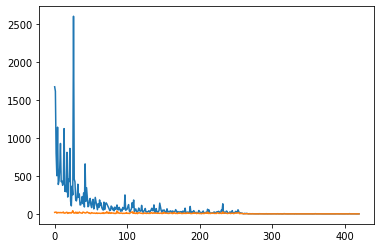

In [ ]:
plt.plot(train_loss)
plt.plot(validation_loss)

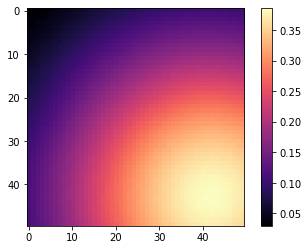

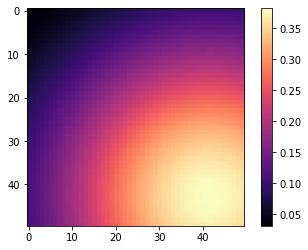

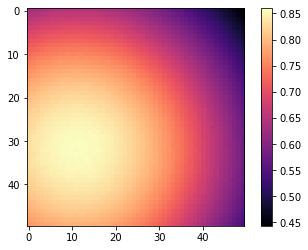

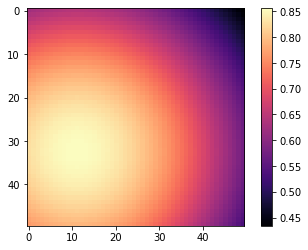

In [ ]:
from random import randint
from numpy import linspace, meshgrid


x,y=meshgrid(linspace(0,1,10),linspace(0,1,10))
f=open("./best_model_tomography_selected_8_tomo_10000_nonuni_x.pth",'rb')
model_test=pickle.load(f)
model_test=model_test.to('cpu')
f.close()
model_test.eval()
with torch.no_grad():
    data,target=next(iter(test_dl))#[randint(0,len(test_dl))]
    predict=model_test(data)
    index=randint(0,49)
    fig=plt.figure(0)
    plt.imshow(np.array(predict[index][0]),cmap="magma")
    plt.colorbar()
    fig=plt.figure(1)
    plt.imshow(np.array(target[index][0]),cmap="magma")
    plt.colorbar()
    fig=plt.figure(2)
    plt.imshow(np.array(predict[index][1]),cmap="magma")
    plt.colorbar()
    fig=plt.figure(3)
    plt.imshow(np.array(target[index][1]),cmap="magma")
    plt.colorbar()

    # ax1=fig.add_subplot(projection='3d')
    # ax1.plot_surface(x,y,np.array(predict[index][0])-np.array(target[index][0]))
    # plt.show()
    # fig=plt.figure(1)
    # ax1=fig.add_subplot(projection='3d')
    # ax1.plot_surface(x,y,np.array(target[index][0]))
    # plt.show()

In [ ]:
# import shutil
# colab_link = "/content/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth"
# gdrive_link = "/content/drive/MyDrive/MAMLAS_data/"
# shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/MAMLAS_data/best_model_tomography_selected_8_tomo_10000_nonuni_x.pth'